In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/TeaDataSet/train'
valid_path = '/content/drive/MyDrive/TeaDataSet/valid'
test_path = '/content/drive/MyDrive/TeaDataSet/test'


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

train_batches = ImageDataGenerator( rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)


Found 706 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 87 images belonging to 8 classes.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   896         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   18496       ['conv2d[0][0]']                 
                                64)                                                           

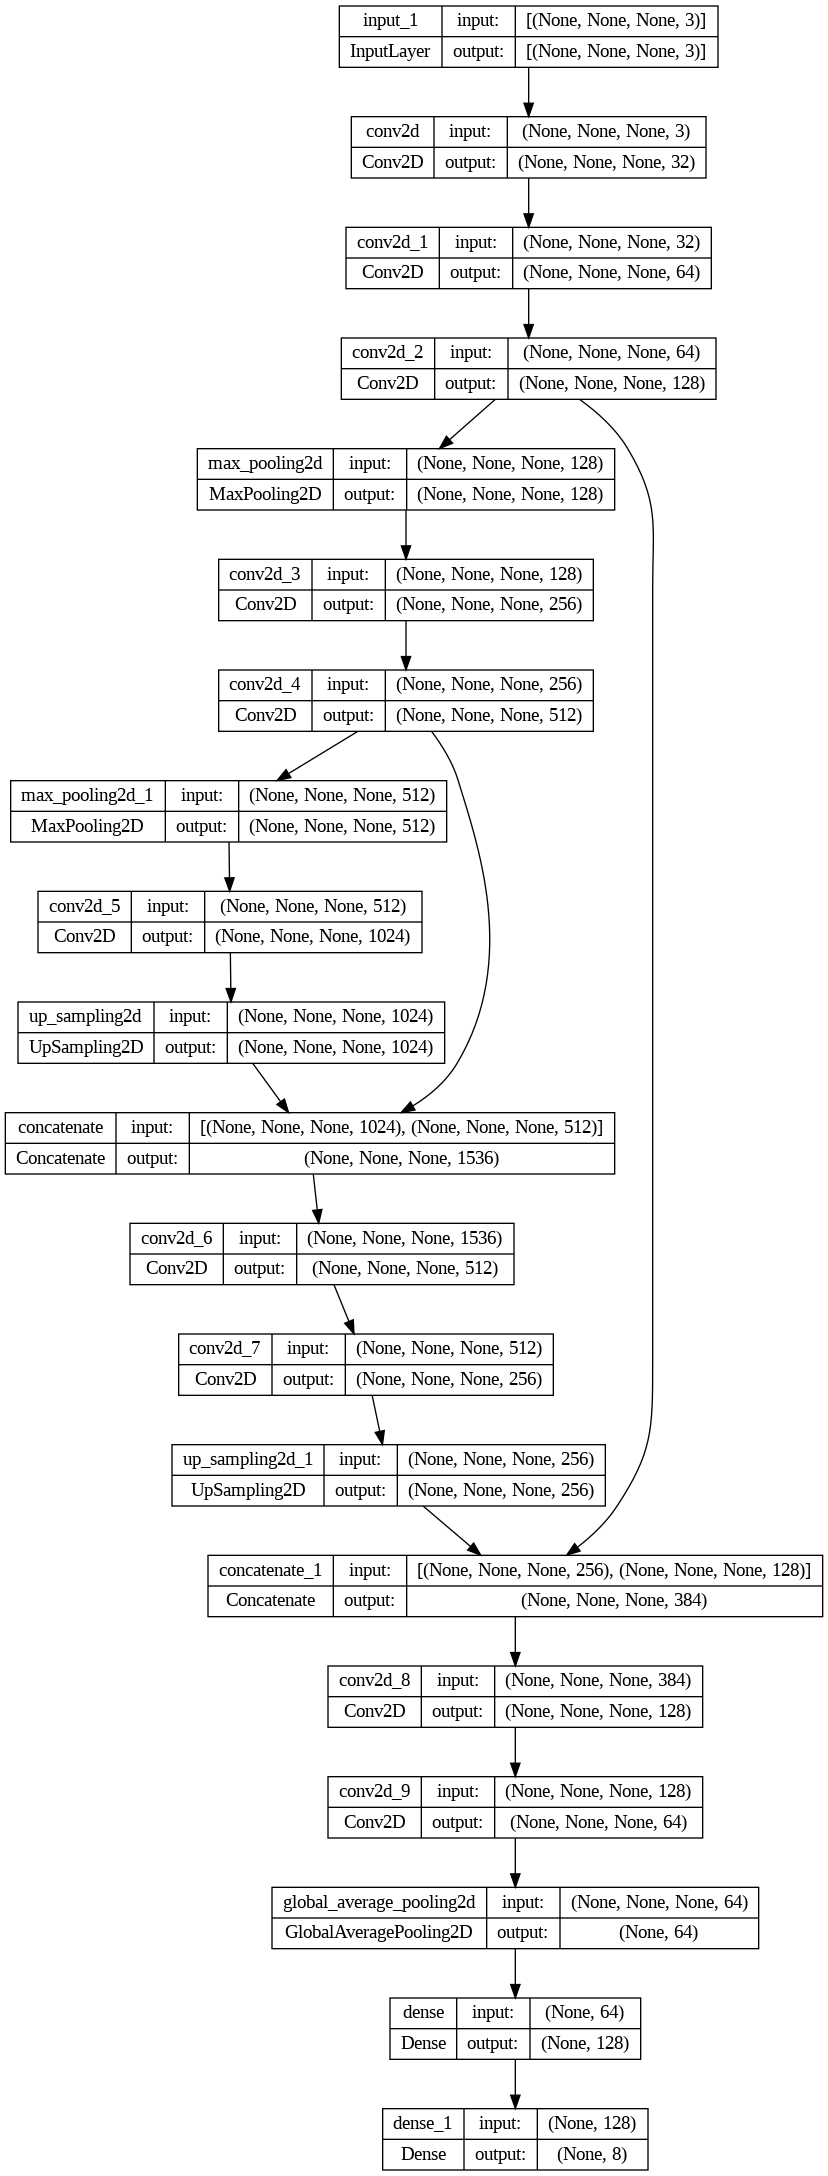

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, GlobalAveragePooling2D, Dense
from keras.models import Model

input_img = Input(shape=(None, None, 3))

# Encoder structure
conv1 = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(input_img)
conv2 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(conv1)
conv3 = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(conv2)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(pool1)
conv5 = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(conv4)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv5)

conv6 = Conv2D(filters=1024, kernel_size=3, padding='same', activation='relu')(pool2)

# Decoder structure
up1 = UpSampling2D(size=(2, 2))(conv6)
concat1 = Concatenate()([up1, conv5])
conv7 = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(concat1)
conv8 = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(conv7)

up2 = UpSampling2D(size=(2, 2))(conv8)
concat2 = Concatenate()([up2, conv3])
conv9 = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(concat2)
conv10 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(conv9)

# Fully Connected layers
gap = GlobalAveragePooling2D()(conv10)
dense1 = Dense(128, activation='relu')(gap)

# Output layer
output = Dense(8, activation='softmax')(dense1)

model = Model(inputs=input_img, outputs=output)

model.summary()

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
import pandas as pd

# Create a table to store the layer information
layer_table = pd.DataFrame(columns=['Layer Type', 'Filter Size', 'Number of Filters', 'Number of Neurons', 'Input Shape', 'Output Shape'])

# Iterate through each layer in the model
for layer in model.layers:
    layer_type = layer.__class__.__name__
    filter_size = None
    num_filters = None
    num_neurons = None
    input_shape = layer.input_shape[1:] if layer.input_shape else None
    output_shape = layer.output_shape[1:] if layer.output_shape else None

    # Check the layer type and extract the relevant information
    if layer_type == 'Conv2D':
        filter_size = layer.kernel_size
        num_filters = layer.filters
    elif layer_type == 'Dense':
        num_neurons = layer.units
    elif layer_type == 'MaxPooling2D':
        filter_size = layer.pool_size
    elif layer_type == 'UpSampling2D':
        filter_size = layer.size

    # Add the information to the table
    layer_table = layer_table.append({'Layer Type': layer_type,
                                      'Filter Size': filter_size,
                                      'Number of Filters': num_filters,
                                      'Number of Neurons': num_neurons,
                                      'Input Shape': input_shape,
                                      'Output Shape': output_shape},
                                     ignore_index=True)

# Export the layer table to an Excel file
layer_table.to_excel('layer_table.xlsx', index=False)

<ipython-input-4-982e8c475aa5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  layer_table = layer_table.append({'Layer Type': layer_type,
<ipython-input-4-982e8c475aa5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  layer_table = layer_table.append({'Layer Type': layer_type,
<ipython-input-4-982e8c475aa5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  layer_table = layer_table.append({'Layer Type': layer_type,
<ipython-input-4-982e8c475aa5>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  layer_table = layer_table.append({'Layer Type': layer_type,
<ipython-input-4-982e8c475aa5>:27: FutureWarning: The frame.append method is dep

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
import json

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callback_list=[EarlyStopping(monitor="val_accuracy",patience=150),ModelCheckpoint(filepath="/content/drive/MyDrive/EncoderDecoderTeaLeafNet.h5",monitor="val_accuracy",save_best_only=True,verbose=1)]

history = model.fit_generator(train_batches,validation_data=valid_batches,epochs=100,verbose=1,callbacks=callback_list)


with open('history.json', 'w') as f:
    json.dump(history.history, f)

<ipython-input-6-2a56d3a4190a>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_batches,validation_data=valid_batches,epochs=100,verbose=1,callbacks=callback_list)


Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 2.0772 - accuracy: 0.1686
Epoch 1: val_accuracy improved from -inf to 0.24138, saving model to /content/drive/MyDrive/EncoderDecoderTeaLeafNet.h5
71/71 [==============================] - 526s 7s/step - loss: 2.0772 - accuracy: 0.1686 - val_loss: 1.5561 - val_accuracy: 0.2414
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 1.3992 - accuracy: 0.3144
Epoch 2: val_accuracy improved from 0.24138 to 0.39080, saving model to /content/drive/MyDrive/EncoderDecoderTeaLeafNet.h5
71/71 [==============================] - 107s 1s/step - loss: 1.3992 - accuracy: 0.3144 - val_loss: 1.2884 - val_accuracy: 0.3908
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 1.2747 - accuracy: 0.3909
Epoch 3: val_accuracy improved from 0.39080 to 0.40230, saving model to /content/drive/MyDrive/EncoderDecoderTeaLeafNet.h5
71/71 [==============================] - 107s 1s/step - loss: 1.2747 - accuracy: 0.3909 -

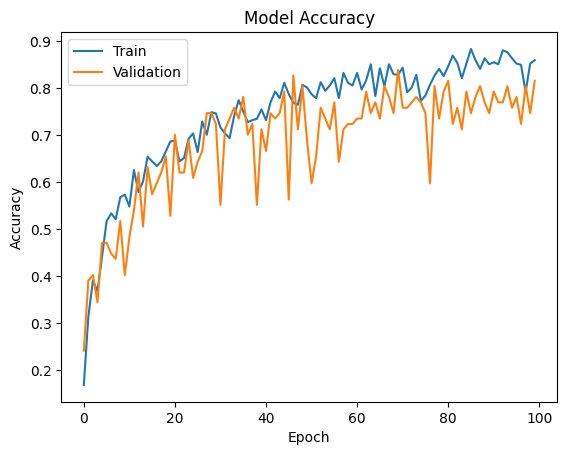

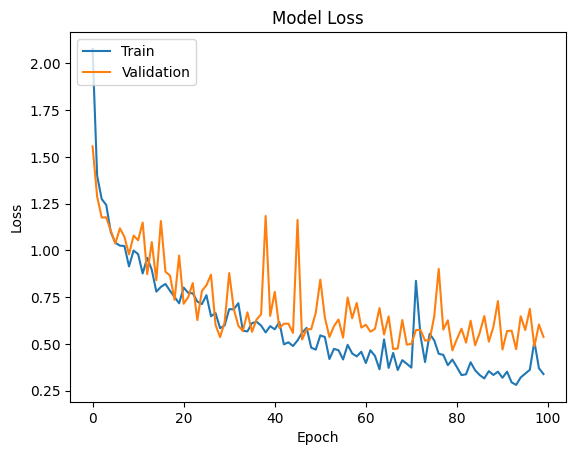

In [ ]:
import matplotlib.pyplot as plt

# plot the training and validation accuracy over time
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plot the training and validation loss over time
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#EVALUATE MODEL AND GENERATE GRAPHS

from tensorflow import keras
from keras.layers import Activation
from keras.utils import get_custom_objects
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Swish activation function
def swish(x):
    return K.sigmoid(x) * x

# Register the Swish function as a custom activation function
get_custom_objects().update({'swish': Activation(swish),'Activation': Activation})

def evaluate_models(models, test_generators):
    num_models = len(models)

    # Loop through each model and corresponding test generator
    for i in range(num_models):
        model = models[i]
        test_generator = test_generators[i]
        print("model.output_shape[-1]  ",model.output_shape[-1])

        # Generate predictions for the test set
        if model.output_shape[-1] == 1:
          # Binary classification with single neuron in last layer
          if isinstance(model.input, list):
            predictions = model.predict([test_generator[0],test_generator[1]], verbose=1)
          else:
            predictions = model.predict(test_generator, verbose=1)
          y_pred = predictions.ravel() > 0.5
        elif model.output_shape[-1] == 2:
          # Binary classification with two neurons in last layer
          predictions = model.predict(test_generator, verbose=1)
          y_pred = np.argmax(predictions, axis=1)
          y_prob = predictions[:, 1] # Use probabilities for positive class
        else:
          # Multi-class classification
          if isinstance(model.input, list):
            predictions = model.predict(test_generator,test_generator.n // test_generator.batch_size+1, verbose=1)
          else:
            print('hooo')
            #test_steps_per_epoch = numpy.math.ceil(test_batches.samples / test_batches.batch_size)
            predictions = model.predict_generator(test_generator,test_generator.n // test_generator.batch_size+1, verbose=1)
          y_pred = np.argmax(predictions, axis=1)
          y_prob = predictions

        # Convert the one-hot encoded labels to integers
        y_true = test_generator.classes

        # Calculate various metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Print the metrics
        print(f"\n\nModel {i+1} Metrics")
        print('Accuracy: {:.4f}'.format(accuracy))
        print('Precision: {:.4f}'.format(precision))
        print('Recall: {:.4f}'.format(recall))
        print('F1-score: {:.4f}'.format(f1))


        # Get the class indices from the test generator
        class_indices = test_generator.class_indices

        # Invert the class indices to get the class labels with sequence
        class_labels = dict((v, k) for k, v in class_indices.items())

        # Map the integer labels to their corresponding class labels
        y_true_labels = [class_labels[label] for label in y_true]
        y_pred_labels = [class_labels[label] for label in y_pred]


        # Print confusion matrix
        cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(class_labels.values()))
        print('Confusion matrix:\n', cm)

        # Plot confusion matrix with actual labels
        sns.set(font_scale=1.4)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, square=True, xticklabels=class_labels.values(), yticklabels=class_labels.values())
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        #bar graph
        metrics_dict={
            'Accuracy':accuracy,
            'Precision':precision,
            'Recall':recall,
            'F1-Score':f1

        }

        plt.bar(metrics_dict.keys(),metrics_dict.values())
        plt.title('Metrics')
        plt.show()

        if model.output_shape[-1] == 1 or model.output_shape[-1] == 2:
            # Binary classification with one or two neurons in last layer
            tn, fp, fn, tp = cm.ravel()
            fpr, tpr, thresholds = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic')
            plt.legend(loc="lower right")
            plt.show()

            # Print ROC curve with class labels
            print("ROC Curve with class labels:")
            for i in range(len(fpr)):
                print("{} {}: {:.2f}".format(y_true_labels[i], class_labels[1], fpr[i]))

        if model.output_shape[-1] != 1 and model.output_shape[-1] != 2:
            # Calculate ROC curve and AUC for multi-class classification
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            n_classes = model.output_shape[-1]

            for j in range(n_classes):
                fpr[j], tpr[j], _ = roc_curve(y_true == j, y_prob[:, j])
                roc_auc[j] = auc(fpr[j], tpr[j])

            # Plot ROC curve
            sns.set(font_scale=1.4)
            plt.figure(figsize=(8, 8))
            for j in range(n_classes):
                plt.plot(fpr[j], tpr[j], label='ROC curve for {} (area = {:.2f})'.format(class_labels[j], roc_auc[j]), linewidth=2)
            plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()

            # Print ROC curve with class labels
            print("ROC Curve with class labels:")
            for j in range(n_classes):
                for i in range(len(fpr[j])):
                    print("{} {}: {:.2f}".format(class_labels[j], y_true_labels[i], fpr[j][i]))




model.output_shape[-1]   8
hooo


<ipython-input-9-add47645ee33>:49: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator,test_generator.n // test_generator.batch_size+1, verbose=1)


9/9 [==============================] - 50s 6s/step


Model 1 Metrics
Accuracy: 0.8736
Precision: 0.8812
Recall: 0.8736
F1-score: 0.8730
Confusion matrix:
 [[ 9  0  0  0  1  0  0  0]
 [ 0 11  0  0  0  0  0  0]
 [ 1  0  8  0  1  0  0  0]
 [ 0  0  0 10  0  0  0  1]
 [ 1  0  1  0  8  0  0  0]
 [ 1  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 14  0]
 [ 0  1  0  3  0  0  0 10]]


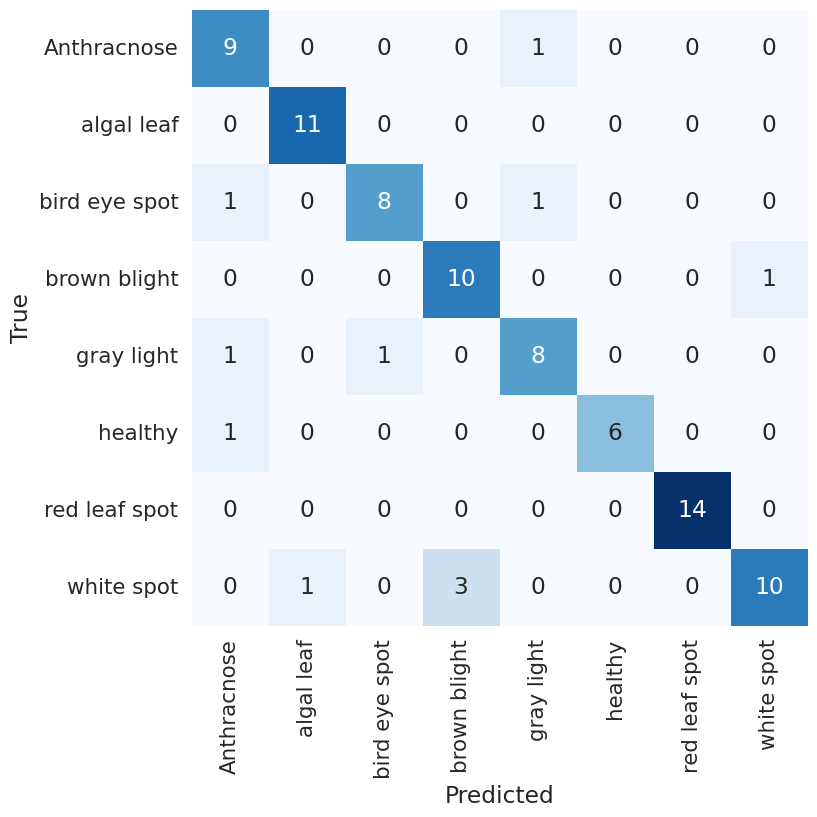

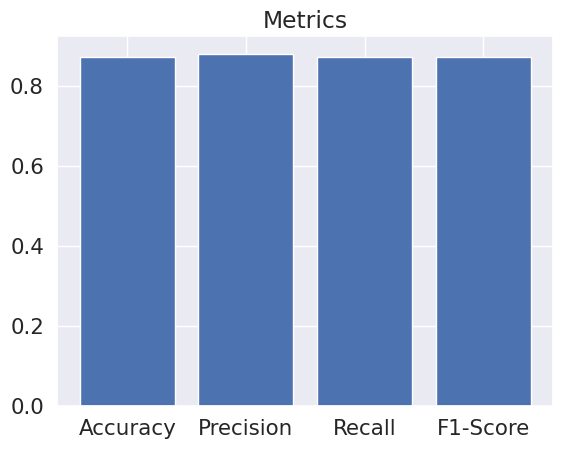

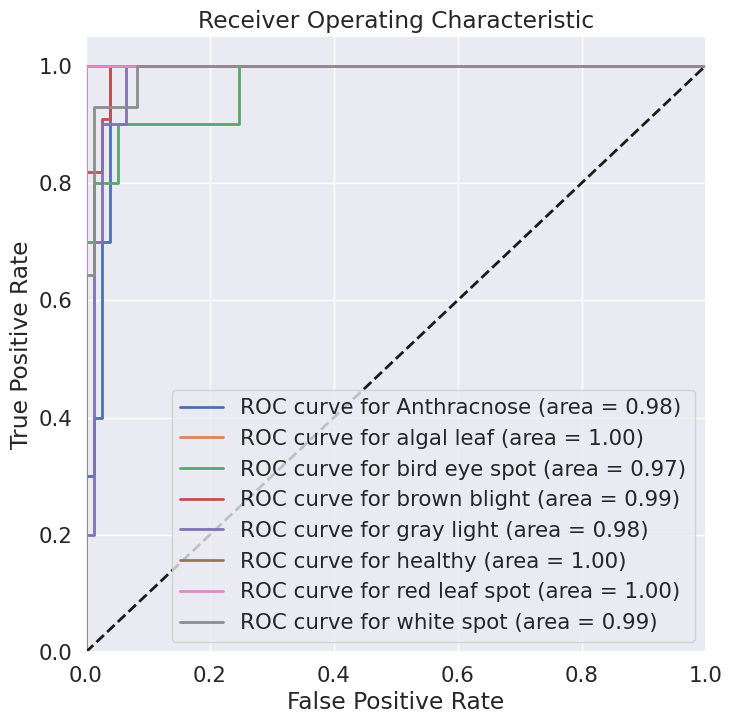

ROC Curve with class labels:
Anthracnose Anthracnose: 0.00
Anthracnose Anthracnose: 0.00
Anthracnose Anthracnose: 0.00
Anthracnose Anthracnose: 0.01
Anthracnose Anthracnose: 0.01
Anthracnose Anthracnose: 0.03
Anthracnose Anthracnose: 0.03
Anthracnose Anthracnose: 0.04
Anthracnose Anthracnose: 0.04
Anthracnose Anthracnose: 1.00
algal leaf Anthracnose: 0.00
algal leaf Anthracnose: 0.00
algal leaf Anthracnose: 0.00
algal leaf Anthracnose: 1.00
bird eye spot Anthracnose: 0.00
bird eye spot Anthracnose: 0.00
bird eye spot Anthracnose: 0.00
bird eye spot Anthracnose: 0.01
bird eye spot Anthracnose: 0.01
bird eye spot Anthracnose: 0.05
bird eye spot Anthracnose: 0.05
bird eye spot Anthracnose: 0.25
bird eye spot Anthracnose: 0.25
bird eye spot Anthracnose: 1.00
brown blight Anthracnose: 0.00
brown blight Anthracnose: 0.00
brown blight Anthracnose: 0.00
brown blight Anthracnose: 0.03
brown blight Anthracnose: 0.03
brown blight Anthracnose: 0.04
brown blight Anthracnose: 0.04
brown blight Anthr

In [ ]:
evaluate_models([model],[test_batches])

In [ ]:
#LOAD AND RETRAIN  MODEL
from keras.layers import Activation
from keras.utils import get_custom_objects
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
import json

# Load the saved model with custom activation function
model = load_model('/content/drive/MyDrive/EncoderDecoderTeaLeafNet.h5')


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callback_list=[EarlyStopping(monitor="val_loss",patience=150),ModelCheckpoint(filepath="/content/drive/MyDrive/EncoderDecoderTeaLeafNet.h5",monitor="val_loss",save_best_only=True,verbose=1)]

history = model.fit_generator(train_batches,validation_data=valid_batches,epochs=100,verbose=1,callbacks=callback_list)


with open('history.json', 'w') as f:
    json.dump(history.history, f)



<ipython-input-8-12b272f0ab94>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_batches,validation_data=valid_batches,epochs=100,verbose=1,callbacks=callback_list)


Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 0.5950 - accuracy: 0.7592
Epoch 1: val_loss improved from inf to 0.58035, saving model to /content/drive/MyDrive/EncoderDecoderTeaLeafNet.h5
71/71 [==============================] - 404s 5s/step - loss: 0.5950 - accuracy: 0.7592 - val_loss: 0.5804 - val_accuracy: 0.7126
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 0.4761 - accuracy: 0.7960
Epoch 2: val_loss improved from 0.58035 to 0.49012, saving model to /content/drive/MyDrive/EncoderDecoderTeaLeafNet.h5
71/71 [==============================] - 109s 2s/step - loss: 0.4761 - accuracy: 0.7960 - val_loss: 0.4901 - val_accuracy: 0.7586
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 0.5072 - accuracy: 0.7691
Epoch 3: val_loss did not improve from 0.49012
71/71 [==============================] - 107s 2s/step - loss: 0.5072 - accuracy: 0.7691 - val_loss: 0.6171 - val_accuracy: 0.7011
Epoch 4/100
71/71 [=========================

KeyboardInterrupt: ignored